# 必要な関数

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm


def gpr_one_kernel(kernel_number,autoscaled_x, autoscaled_y,x):
    # カーネル 11 種類
    kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
    model.fit(autoscaled_x, autoscaled_y)

    return model





def validate_model(regression_method, model,fold_number, autoscaled_x, autoscaled_y, x, y):
     # クロスバリデーションの fold 数
    fold_number = fold_number
    
    # トレーニングデータの推定(実験データ)
    autoscaled_estimated_y = model.predict(autoscaled_x)  # y の推定
    estimated_y = autoscaled_estimated_y * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y = pd.DataFrame(estimated_y, index=x.index, columns=['estimated_y'])

    # トレーニングデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # トレーニングデータのr2, RMSE, MAE
    print('r^2 for training data :', r2_score(y, estimated_y))
    print('RMSE for training data :', mean_squared_error(y, estimated_y, squared=False))
    print('MAE for training data :', mean_absolute_error(y, estimated_y))

    # トレーニングデータの結果の保存
    y_for_save = pd.DataFrame(y)
    y_for_save.columns = ['actual_y']
    y_error_train = y_for_save.iloc[:, 0] - estimated_y.iloc[:, 0]
    y_error_train = pd.DataFrame(y_error_train)
    y_error_train.columns = ['error_of_y(actual_y-estimated_y)']
    results_train = pd.concat([y_for_save, estimated_y, y_error_train], axis=1) # 結合
    results_train.to_csv('./../results/validation/estimated_y_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    
    # クロスバリデーションによる y の値の推定
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
    autoscaled_estimated_y_in_cv = cross_val_predict(model, autoscaled_x, autoscaled_y, cv=cross_validation)  # y の推定
    estimated_y_in_cv = autoscaled_estimated_y_in_cv * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y_in_cv = pd.DataFrame(estimated_y_in_cv, index=x.index, columns=['estimated_y'])

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y_in_cv.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y_in_cv.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y_in_cv.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # クロスバリデーションにおけるr2, RMSE, MAE
    print('r^2 in cross-validation :', r2_score(y, estimated_y_in_cv))
    print('RMSE in cross-validation :', mean_squared_error(y, estimated_y_in_cv, squared=False))
    print('MAE in cross-validation :', mean_absolute_error(y, estimated_y_in_cv))

    # クロスバリデーションの結果の保存
    y_error_in_cv = y_for_save.iloc[:, 0] - estimated_y_in_cv.iloc[:, 0]
    y_error_in_cv = pd.DataFrame(y_error_in_cv)
    y_error_in_cv.columns = ['error_of_y(actual_y-estimated_y)']
    results_in_cv = pd.concat([y_for_save, estimated_y_in_cv, y_error_in_cv], axis=1) # 結合
    results_in_cv.to_csv('./../results/validation/estimated_y_in_cv_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    


    

def predict(regression_method, model, autoscaled_x_prediction, x_prediction, y):
    estimated_y_prediction_std = None

    if regression_method == 'gpr_one_kernel' or regression_method == 'gpr_kernels':  # 標準偏差あり
        estimated_y_prediction, estimated_y_prediction_std = model.predict(
            autoscaled_x_prediction, return_std=True)
        estimated_y_prediction_std = estimated_y_prediction_std * y.std()
        estimated_y_prediction_std = pd.DataFrame(
            estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
            regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    else:
        estimated_y_prediction = model.predict(autoscaled_x_prediction)

    estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。

    return estimated_y_prediction, estimated_y_prediction_std



def acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method):
    target_range = [0, 100]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI

    cumulative_variance = np.zeros(
        x_prediction.shape[0])  # MI で必要な "ばらつき" を 0 で初期化
    if acquisition_function == 'MI':
        acquisition_function_prediction = estimated_y_prediction + np.log(2 / delta) ** 0.5 * (
            (estimated_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
        cumulative_variance = cumulative_variance + estimated_y_prediction_std ** 2
    elif acquisition_function == 'EI':
        acquisition_function_prediction = (estimated_y_prediction - max(y) - relaxation * y.std()) * \
            norm.cdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std) + \
            estimated_y_prediction_std * \
            norm.pdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std)
    elif acquisition_function == 'PI':
        acquisition_function_prediction = norm.cdf(
            (estimated_y_prediction - max(y) - relaxation * y.std()) / estimated_y_prediction_std)
    elif acquisition_function == 'PTR':
        acquisition_function_prediction = norm.cdf(target_range[1],
                                                   loc=estimated_y_prediction,
                                                   scale=estimated_y_prediction_std
                                                   ) - norm.cdf(target_range[0],
                                                                loc=estimated_y_prediction,
                                                                scale=estimated_y_prediction_std)
        
    acquisition_function_prediction[estimated_y_prediction_std <= 0] = 0

    # 保存
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    estimated_y_prediction_std = pd.DataFrame(
        estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
        regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    acquisition_function_prediction = pd.DataFrame(
        acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(
        regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    return estimated_y_prediction, acquisition_function_prediction, acquisition_function



# ベイズ最適化

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


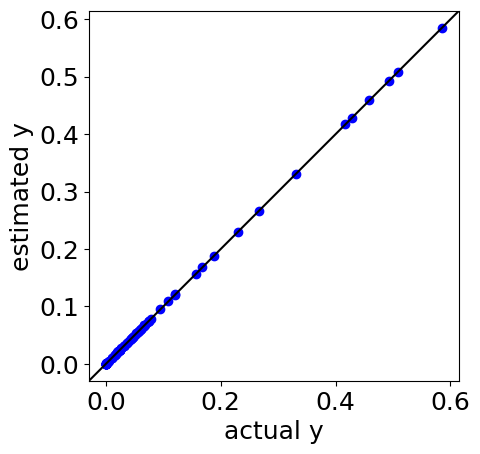

r^2 for training data : 0.9999999988605098
RMSE for training data : 4.176903109909923e-06
MAE for training data : 2.5875655055612933e-06


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

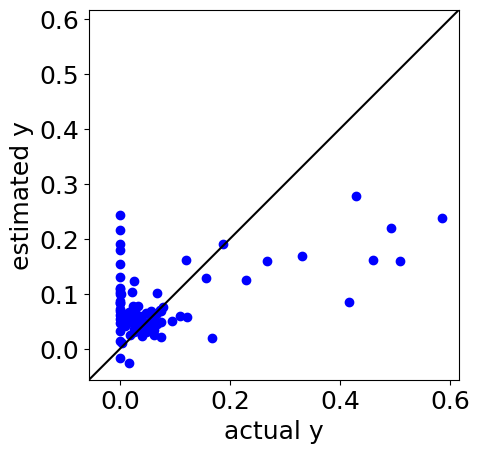

r^2 in cross-validation : 0.28699630577922286
RMSE in cross-validation : 0.10448284814385025
MAE in cross-validation : 0.06628573967447773
     estimated_y
2       0.113333
5       0.096463
8       0.059551
11      0.122359
14      0.096864
..           ...
724     0.057119
725     0.059844
726     0.065998
727     0.071853
728     0.068183

[609 rows x 1 columns]
[[0.80516142]
 [0.76181795]
 [0.67099145]
 [0.8191979 ]
 [0.76414733]
 [0.69505188]
 [0.92248735]
 [0.87023929]
 [0.75038321]
 [0.83565283]
 [0.78683936]
 [0.7107591 ]
 [0.70796188]
 [0.68636003]
 [0.68331503]
 [0.18835245]
 [0.0615067 ]
 [0.30834785]
 [0.06299771]
 [0.21662558]
 [0.54725668]
 [0.78326248]
 [0.47396846]
 [0.31143314]
 [0.49613967]
 [0.18000712]
 [0.36961645]
 [0.62210593]
 [0.90539456]
 [0.7741833 ]
 [0.68124022]
 [0.6725803 ]
 [0.64640671]
 [0.66342392]
 [0.58898009]
 [0.63282989]
 [0.68021629]
 [0.91454136]
 [0.5260347 ]
 [0.48733203]
 [0.48183076]
 [0.36666841]
 [0.53283512]
 [0.42054209]
 [0.49752224]
 [0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.118231
5       0.099670
8       0.059854
11      0.127236
14      0.100249
..           ...
724     0.057909
725     0.060503
726     0.067033
727     0.073013
728     0.069179

[608 rows x 1 columns]
[[0.81565597]
 [0.76913192]
 [0.6718481 ]
 [0.82882537]
 [0.77196764]
 [0.69812135]
 [0.93035034]
 [0.8794475 ]
 [0.75687117]
 [0.8459637 ]
 [0.795824  ]
 [0.71574522]
 [0.71073597]
 [0.68909699]
 [0.68598262]
 [0.17865898]
 [0.05349671]
 [0.29317264]
 [0.05341672]
 [0.19762463]
 [0.5373251 ]
 [0.7807258 ]
 [0.4662542 ]
 [0.29827631]
 [0.48618887]
 [0.16614945]
 [0.3541388 ]
 [0.6177034 ]
 [0.90861793]
 [0.77574666]
 [0.68187336]
 [0.67595865]
 [0.64645819]
 [0.66328146]
 [0.58854481]
 [0.63291276]
 [0.68142209]
 [0.91455037]
 [0.51859543]
 [0.47932167]
 [0.47428414]
 [0.35321266]
 [0.52400084]
 [0.40926775]
 [0.48612192]
 [0.63634806]
 [0.89474219]
 [0.63673384]
 [0.58432648]
 [0.53177709]
 [0.46592126]
 [0.57990896]
 [0.47769113]
 [0.51681741]
 [0.62929373]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.121750
5       0.102539
8       0.060682
11      0.131095
14      0.103017
..           ...
724     0.059155
725     0.061716
726     0.068665
727     0.074739
728     0.070758

[606 rows x 1 columns]
[[0.84247139]
 [0.78191028]
 [0.67505689]
 [0.84151827]
 [0.78072199]
 [0.70252961]
 [0.93732258]
 [0.88796534]
 [0.76470073]
 [0.85526094]
 [0.80398775]
 [0.72160817]
 [0.71588738]
 [0.69277196]
 [0.69004919]
 [0.1635374 ]
 [0.04735666]
 [0.27918673]
 [0.04932231]
 [0.18610476]
 [0.53142864]
 [0.78043657]
 [0.4584536 ]
 [0.2864438 ]
 [0.47723326]
 [0.16021983]
 [0.34446679]
 [0.61560014]
 [0.91274139]
 [0.7792459 ]
 [0.6845129 ]
 [0.68032985]
 [0.64724896]
 [0.66429679]
 [0.59124883]
 [0.63408536]
 [0.68351879]
 [0.91715749]
 [0.51365042]
 [0.4723553 ]
 [0.46764019]
 [0.34138308]
 [0.5172826 ]
 [0.40268575]
 [0.47919189]
 [0.63636617]
 [0.89654158]
 [0.63279692]
 [0.58111068]
 [0.52542484]
 [0.45572938]
 [0.57578635]
 [0.47307424]
 [0.51113368]
 [0.62938181]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


     estimated_y
2       0.121866
5       0.103373
8       0.061741
11      0.131499
14      0.103795
..           ...
724     0.060357
725     0.062905
726     0.070340
727     0.076530
728     0.072389

[604 rows x 1 columns]
[[0.84363942]
 [0.78492818]
 [0.67857877]
 [0.85554371]
 [0.78738223]
 [0.70609536]
 [0.95530336]
 [0.89859115]
 [0.77414913]
 [0.86892792]
 [0.81180757]
 [0.72721914]
 [0.72107391]
 [0.69620513]
 [0.69390538]
 [0.15286607]
 [0.04052485]
 [0.2650951 ]
 [0.04368949]
 [0.17239866]
 [0.52446186]
 [0.77718616]
 [0.44739873]
 [0.27126625]
 [0.46554377]
 [0.15051511]
 [0.33117102]
 [0.61143154]
 [0.92043361]
 [0.78212061]
 [0.68608683]
 [0.68489651]
 [0.64621301]
 [0.66398713]
 [0.59187092]
 [0.63270895]
 [0.68422618]
 [0.92043432]
 [0.51268325]
 [0.468261  ]
 [0.46425731]
 [0.33169504]
 [0.51171347]
 [0.39522684]
 [0.4711429 ]
 [0.6362732 ]
 [0.89990202]
 [0.6304972 ]
 [0.57876632]
 [0.52153107]
 [0.44624116]
 [0.57195092]
 [0.46746079]
 [0.50418419]
 [0.62949647]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihi

     estimated_y
2       0.122435
5       0.103713
8       0.062143
11      0.131619
14      0.104090
..           ...
724     0.060851
725     0.063259
726     0.070941
727     0.077339
728     0.072987

[603 rows x 1 columns]
[[0.84515841]
 [0.78613277]
 [0.67990844]
 [0.85611984]
 [0.78870456]
 [0.70771578]
 [0.95801061]
 [0.91261598]
 [0.78210835]
 [0.87445531]
 [0.81948905]
 [0.73067428]
 [0.72304419]
 [0.69764895]
 [0.69570212]
 [0.15314969]
 [0.03812228]
 [0.26224113]
 [0.03971111]
 [0.16527896]
 [0.52191905]
 [0.76953111]
 [0.43998027]
 [0.26175938]
 [0.45929049]
 [0.14287783]
 [0.32301008]
 [0.60923692]
 [0.92368943]
 [0.78190708]
 [0.68414289]
 [0.68658483]
 [0.64351093]
 [0.66209596]
 [0.59060832]
 [0.63129305]
 [0.68421291]
 [0.92188597]
 [0.50959503]
 [0.46670817]
 [0.4594242 ]
 [0.32450902]
 [0.50905287]
 [0.38756662]
 [0.4645119 ]
 [0.63550024]
 [0.90202454]
 [0.62515735]
 [0.57545102]
 [0.51664345]
 [0.43763275]
 [0.5685536 ]
 [0.46142801]
 [0.49796787]
 [0.62857513]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihi

     estimated_y
2       0.127054
5       0.106855
8       0.063423
11      0.135114
14      0.106674
..           ...
724     0.061984
725     0.064515
726     0.072557
727     0.078895
728     0.074539

[601 rows x 1 columns]
[[0.85714819]
 [0.7952896 ]
 [0.6849728 ]
 [0.86584517]
 [0.79687636]
 [0.71337912]
 [0.9560123 ]
 [0.79013481]
 [0.92640643]
 [0.8396049 ]
 [0.73648447]
 [0.728243  ]
 [0.70186592]
 [0.70007147]
 [0.15534711]
 [0.03700882]
 [0.26330583]
 [0.03770427]
 [0.16267378]
 [0.52434532]
 [0.76844405]
 [0.4404652 ]
 [0.25847072]
 [0.46015265]
 [0.13989114]
 [0.32137932]
 [0.61286187]
 [0.93749697]
 [0.78649387]
 [0.6872584 ]
 [0.69246659]
 [0.64538915]
 [0.66499492]
 [0.5937965 ]
 [0.63470616]
 [0.68844399]
 [0.92315984]
 [0.51180642]
 [0.47231099]
 [0.46215671]
 [0.32640013]
 [0.51411898]
 [0.39091531]
 [0.4678794 ]
 [0.6404661 ]
 [0.90398451]
 [0.62544585]
 [0.57916965]
 [0.51789192]
 [0.43706142]
 [0.57140201]
 [0.46422582]
 [0.4992936 ]
 [0.63173659]
 [0.76908147]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


     estimated_y
2       0.129825
5       0.108757
8       0.064393
11      0.136609
14      0.107926
..           ...
724     0.061992
725     0.064013
726     0.072346
727     0.078837
728     0.074015

[599 rows x 1 columns]
[[0.86499641]
 [0.80143479]
 [0.68901453]
 [0.88619649]
 [0.80648333]
 [0.71771293]
 [0.85033154]
 [0.95007795]
 [0.88502404]
 [0.75536388]
 [0.73655514]
 [0.70613593]
 [0.70398033]
 [0.15579543]
 [0.03547237]
 [0.26261831]
 [0.03585131]
 [0.15937431]
 [0.52532775]
 [0.76422405]
 [0.43086822]
 [0.24653169]
 [0.4543123 ]
 [0.13590562]
 [0.3167823 ]
 [0.61359643]
 [0.94060573]
 [0.79498761]
 [0.68889106]
 [0.69326339]
 [0.64330531]
 [0.66487241]
 [0.59460796]
 [0.63570481]
 [0.69048822]
 [0.925567  ]
 [0.5094084 ]
 [0.47203658]
 [0.45823952]
 [0.32055086]
 [0.51319293]
 [0.38724328]
 [0.46460802]
 [0.64115645]
 [0.90794612]
 [0.61987761]
 [0.57604985]
 [0.51388849]
 [0.42837447]
 [0.56857046]
 [0.46121125]
 [0.49493165]
 [0.6315174 ]
 [0.76802376]
 [0.70180789]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.130449
5       0.109013
8       0.063123
11      0.136889
14      0.107615
..           ...
724     0.063324
725     0.065057
726     0.073649
727     0.080668
728     0.075529

[597 rows x 1 columns]
[[0.8672876 ]
 [0.80734435]
 [0.68679484]
 [0.88870973]
 [0.82361457]
 [0.72030329]
 [0.85299749]
 [0.95224184]
 [0.90495074]
 [0.76307659]
 [0.73482474]
 [0.70886164]
 [0.70626881]
 [0.13794278]
 [0.02914486]
 [0.23998685]
 [0.03067735]
 [0.14212639]
 [0.51002367]
 [0.7541477 ]
 [0.40628028]
 [0.22423121]
 [0.43059554]
 [0.12545276]
 [0.29815773]
 [0.60330585]
 [0.94280017]
 [0.78880319]
 [0.67996294]
 [0.69120252]
 [0.63376564]
 [0.65669338]
 [0.59230719]
 [0.63173576]
 [0.68802315]
 [0.92700118]
 [0.4939111 ]
 [0.45283142]
 [0.43869747]
 [0.29483025]
 [0.49398369]
 [0.36644264]
 [0.44387198]
 [0.63351696]
 [0.91007633]
 [0.60530884]
 [0.56076977]
 [0.49759468]
 [0.4044469 ]
 [0.5536748 ]
 [0.4454248 ]
 [0.47820188]
 [0.62575881]
 [0.76627242]
 [0.69971995]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.133689
5       0.110282
8       0.061647
11      0.139303
14      0.108360
..           ...
724     0.063887
725     0.065181
726     0.074066
727     0.081220
728     0.075721

[595 rows x 1 columns]
[[0.87528981]
 [0.82230502]
 [0.68555189]
 [0.89548313]
 [0.82768005]
 [0.71981747]
 [0.85676274]
 [0.95520779]
 [0.90779622]
 [0.76416279]
 [0.73443157]
 [0.70819174]
 [0.70668418]
 [0.11901017]
 [0.02250788]
 [0.21327885]
 [0.02476877]
 [0.12228994]
 [0.49067662]
 [0.75026797]
 [0.38618929]
 [0.20534718]
 [0.40806415]
 [0.11336604]
 [0.27786244]
 [0.59228125]
 [0.94358896]
 [0.78461104]
 [0.67371645]
 [0.69013161]
 [0.62686318]
 [0.65025653]
 [0.59136349]
 [0.62967606]
 [0.68673981]
 [0.92690299]
 [0.47946542]
 [0.43346322]
 [0.42303327]
 [0.27228309]
 [0.4735775 ]
 [0.34784805]
 [0.42337435]
 [0.62418289]
 [0.91018058]
 [0.59337148]
 [0.54715631]
 [0.48424353]
 [0.38423098]
 [0.53919918]
 [0.43109099]
 [0.46230829]
 [0.61912169]
 [0.76638169]
 [0.69854988]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.136487
5       0.111427
8       0.060233
11      0.140922
14      0.108729
..           ...
724     0.064330
725     0.064938
726     0.073969
727     0.081520
728     0.075474

[593 rows x 1 columns]
[[0.88209839]
 [0.82635367]
 [0.68219015]
 [0.90121004]
 [0.83144332]
 [0.7189652 ]
 [0.88070157]
 [0.95160766]
 [0.77078326]
 [0.76816945]
 [0.7151201 ]
 [0.70695853]
 [0.10419174]
 [0.018114  ]
 [0.19224637]
 [0.02075469]
 [0.10724013]
 [0.47334798]
 [0.73688114]
 [0.3597333 ]
 [0.1840005 ]
 [0.38308515]
 [0.10343567]
 [0.2595811 ]
 [0.58098409]
 [0.94553651]
 [0.77462898]
 [0.66250785]
 [0.69236413]
 [0.61529235]
 [0.64020682]
 [0.58975106]
 [0.62681741]
 [0.68456069]
 [0.9268708 ]
 [0.46576948]
 [0.41571034]
 [0.40746634]
 [0.25173789]
 [0.45431359]
 [0.33065085]
 [0.40399036]
 [0.6142972 ]
 [0.91200819]
 [0.57804623]
 [0.53070519]
 [0.47064574]
 [0.36203713]
 [0.52300889]
 [0.41716994]
 [0.44567229]
 [0.6114943 ]
 [0.76307302]
 [0.69455827]
 [0.72046472]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.140181
5       0.112793
8       0.057984
11      0.143002
14      0.109208
..           ...
724     0.064739
725     0.064357
726     0.073340
727     0.081438
728     0.074597

[591 rows x 1 columns]
[[0.89020951]
 [0.83110756]
 [0.67619839]
 [0.90774403]
 [0.84587631]
 [0.72011748]
 [0.88395829]
 [0.82346066]
 [0.76153612]
 [0.74425425]
 [0.72230355]
 [0.08947623]
 [0.01422766]
 [0.17002661]
 [0.01676601]
 [0.09145308]
 [0.45186615]
 [0.71853042]
 [0.32782355]
 [0.15643859]
 [0.35259195]
 [0.09276328]
 [0.23712937]
 [0.56671495]
 [0.94715274]
 [0.75932312]
 [0.64395265]
 [0.68729582]
 [0.6021074 ]
 [0.6281749 ]
 [0.58638627]
 [0.62579781]
 [0.68251091]
 [0.92577064]
 [0.44308901]
 [0.39007191]
 [0.38228154]
 [0.22333898]
 [0.42725382]
 [0.30536604]
 [0.37674856]
 [0.59919044]
 [0.91306235]
 [0.554358  ]
 [0.50632139]
 [0.44911796]
 [0.33164057]
 [0.49999145]
 [0.39677083]
 [0.42262363]
 [0.6000388 ]
 [0.75607369]
 [0.68653259]
 [0.71669006]
 [0.63880215]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.142570
5       0.113467
8       0.056521
11      0.144528
14      0.109621
..           ...
724     0.065084
725     0.064238
726     0.073329
727     0.081632
728     0.074412

[589 rows x 1 columns]
[[0.89594921]
 [0.83431913]
 [0.67280858]
 [0.91284508]
 [0.84986569]
 [0.71960899]
 [0.8875068 ]
 [0.82709529]
 [0.75953814]
 [0.74436403]
 [0.72392669]
 [0.07842556]
 [0.01109049]
 [0.15192155]
 [0.01326518]
 [0.07807916]
 [0.43344475]
 [0.7106898 ]
 [0.30897378]
 [0.14087063]
 [0.33220377]
 [0.0827861 ]
 [0.21954888]
 [0.55525264]
 [0.78814499]
 [0.63591373]
 [0.73384259]
 [0.60025827]
 [0.62102771]
 [0.58539078]
 [0.6239501 ]
 [0.6810806 ]
 [0.92566207]
 [0.43316577]
 [0.37617415]
 [0.37204175]
 [0.20886246]
 [0.41088649]
 [0.29106618]
 [0.35962953]
 [0.58958892]
 [0.92065407]
 [0.54373575]
 [0.49401143]
 [0.43893134]
 [0.31484402]
 [0.48678605]
 [0.38488013]
 [0.40798907]
 [0.59316491]
 [0.75431136]
 [0.68392516]
 [0.71741964]
 [0.63620905]
 [0.64915658]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.146802
5       0.116087
8       0.056397
11      0.147393
14      0.111321
..           ...
724     0.065580
725     0.064709
726     0.073998
727     0.082002
728     0.074721

[587 rows x 1 columns]
[[0.90467507]
 [0.84197375]
 [0.67340904]
 [0.9189062 ]
 [0.85584202]
 [0.72201046]
 [0.89031599]
 [0.82993243]
 [0.76526862]
 [0.74734851]
 [0.7258357 ]
 [0.07483725]
 [0.01009973]
 [0.14564247]
 [0.0119887 ]
 [0.07305878]
 [0.42705523]
 [0.71260033]
 [0.3054416 ]
 [0.13807435]
 [0.32704089]
 [0.0793403 ]
 [0.21424691]
 [0.55335114]
 [0.78982021]
 [0.63585237]
 [0.73671193]
 [0.6019844 ]
 [0.62094907]
 [0.58875438]
 [0.6267706 ]
 [0.68278972]
 [0.92466703]
 [0.42558778]
 [0.36994467]
 [0.36440863]
 [0.20118115]
 [0.40441467]
 [0.28472326]
 [0.3530757 ]
 [0.58723727]
 [0.91867869]
 [0.53837613]
 [0.48995294]
 [0.43216807]
 [0.30809851]
 [0.48226278]
 [0.38002602]
 [0.40320164]
 [0.59155592]
 [0.75562416]
 [0.68502116]
 [0.71852021]
 [0.63675068]
 [0.64975064]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.150720
5       0.118756
8       0.056611
11      0.149785
14      0.112952
..           ...
724     0.066108
725     0.064996
726     0.074330
727     0.082331
728     0.074851

[585 rows x 1 columns]
[[0.91330145]
 [0.85135491]
 [0.67562326]
 [0.9249611 ]
 [0.8628746 ]
 [0.72517991]
 [0.89279881]
 [0.83242034]
 [0.76444891]
 [0.74695422]
 [0.72720145]
 [0.07357057]
 [0.0099284 ]
 [0.14440078]
 [0.01195941]
 [0.07251987]
 [0.42700117]
 [0.70756848]
 [0.29895936]
 [0.13481521]
 [0.32319297]
 [0.07947629]
 [0.21396102]
 [0.55483794]
 [0.78630392]
 [0.6316868 ]
 [0.73744422]
 [0.59906483]
 [0.61881061]
 [0.59181447]
 [0.62965907]
 [0.68488736]
 [0.9246944 ]
 [0.41909702]
 [0.36595657]
 [0.3577484 ]
 [0.19578119]
 [0.40136951]
 [0.28224363]
 [0.35097821]
 [0.58724596]
 [0.91890211]
 [0.53112317]
 [0.48511609]
 [0.42600977]
 [0.30119992]
 [0.47857847]
 [0.37823007]
 [0.40073839]
 [0.59103647]
 [0.75421141]
 [0.68430945]
 [0.71786351]
 [0.63450031]
 [0.64959911]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.154599
5       0.121085
8       0.056844
11      0.152043
14      0.114298
..           ...
724     0.066259
725     0.065030
726     0.074708
727     0.082427
728     0.074793

[583 rows x 1 columns]
[[0.92024021]
 [0.85784314]
 [0.67781917]
 [0.92927585]
 [0.86751972]
 [0.72802363]
 [0.89322963]
 [0.83399257]
 [0.76600866]
 [0.74900309]
 [0.73077802]
 [0.07698625]
 [0.00934029]
 [0.14465645]
 [0.00973953]
 [0.06666031]
 [0.42318964]
 [0.70584922]
 [0.299971  ]
 [0.13310382]
 [0.32260046]
 [0.07225266]
 [0.20664044]
 [0.55379778]
 [0.78460323]
 [0.63034766]
 [0.7403549 ]
 [0.59919239]
 [0.61833301]
 [0.59174405]
 [0.63081088]
 [0.6863369 ]
 [0.92326138]
 [0.41171125]
 [0.36494722]
 [0.35065821]
 [0.18954988]
 [0.39931118]
 [0.27266306]
 [0.34252022]
 [0.5851557 ]
 [0.91727316]
 [0.52459914]
 [0.48290961]
 [0.41971665]
 [0.29478416]
 [0.47613302]
 [0.37073154]
 [0.39401989]
 [0.58942506]
 [0.75254748]
 [0.68392523]
 [0.71957493]
 [0.63417923]
 [0.64928134]
 [

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     estimated_y
2       0.157938
5       0.122759
8       0.055916
14      0.115009
17      0.067682
..           ...
724     0.066710
725     0.065257
726     0.075128
727     0.082601
728     0.074731

[581 rows x 1 columns]
[[0.96709095]
 [0.88151321]
 [0.67658057]
 [0.93004662]
 [0.73067144]
 [0.92420619]
 [0.84916493]
 [0.76750781]
 [0.7505318 ]
 [0.73256047]
 [0.06754258]
 [0.00817624]
 [0.13401979]
 [0.00843857]
 [0.06044133]
 [0.41251561]
 [0.70660496]
 [0.28041405]
 [0.12725203]
 [0.30882883]
 [0.06792047]
 [0.19857445]
 [0.5487472 ]
 [0.78481365]
 [0.6280746 ]
 [0.74328184]
 [0.59927007]
 [0.61626322]
 [0.59414358]
 [0.63273018]
 [0.68712174]
 [0.92179622]
 [0.40055022]
 [0.35418128]
 [0.33977006]
 [0.17864606]
 [0.38809993]
 [0.26257734]
 [0.33160463]
 [0.57947846]
 [0.91509069]
 [0.51553921]
 [0.47454368]
 [0.40975157]
 [0.28420352]
 [0.46764238]
 [0.36237369]
 [0.38556016]
 [0.58548213]
 [0.75263132]
 [0.68314492]
 [0.71997651]
 [0.63369938]
 [0.64864364]
 [0.66476234]
 [

In [60]:
# remaining_samples_path, date, 出力するremaining_samplesのpathをラウンドごとに調整する

import os
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 30

# ファイルのパスを定義
generated_samples_path = './../data/generated_samples.csv'
remaining_samples_path = './../data/remaining_samples_4.csv'

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/result_2.csv', index_col=0, header=0)

if os.path.exists(remaining_samples_path):
    x_prediction = pd.read_csv(remaining_samples_path, index_col=0, header=0)
elif os.path.exists(generated_samples_path):
    x_prediction = pd.read_csv(generated_samples_path, index_col=0, header=0)


# 実験条件の全候補のインデックスのリスト
all_indexes = x_prediction.index.tolist()

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = 'PTR' #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)
    estimated_y_prediction, acquisition_function_prediction, acquisition_function = acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    print(estimated_y_prediction_std)
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('./../data/estimated_y_prediction_{0}.csv'.format(regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        estimated_y_prediction_std.to_csv('./../data/estimated_y_prediction_{0}_std.csv'.format(regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        acquisition_function_prediction.to_csv('./../data/acquisition_function_prediction_{0}_{1}.csv'.format(regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))

# 実験日の日付
date = "2024-01-26"
x_prediction.to_csv('./../data/remaining_samples_5.csv')
next_samples.to_csv(f'./../data/next_samples_bo_{date}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください